In [1]:
import torch
from torch import nn, optim, cuda
from torch.optim import lr_scheduler
from torch.backends import cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

cudnn.benchmark = True
device = "cuda" if cuda.is_available() else "cpu"

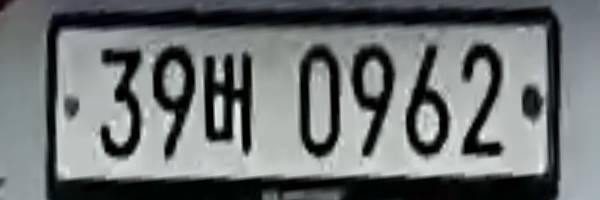

In [2]:
Image.open("./nguyen/train/w/220401T103719.693.png")

In [3]:
def check_size(path: str):
    raw_images = pathlib.Path(path)
    lp_types = {
        "e": list(raw_images.glob("./e*/*.png")),
        "g": list(raw_images.glob("./g*/*.png")),
        "w": list(raw_images.glob("./w*/*.png")),
        "y": list(raw_images.glob("./y*/*.png"))
    }
    return list(map(len, lp_types.values()))
# check_size("./nguyen copy/train/")
check_size("./nguyen/train/")

[1488, 2355, 13264, 2736]

In [4]:
import torch
TRAIN_PATH = "./nguyen/train/"
VAL_PATH = "./nguyen/val/"
TEST_PATH = "./nguyen/test/"

normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                 std=[1.0, 1.0, 1.0])

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=test_transforms)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=True
)

dataset_sizes = len(train_dataset)
class_names = train_dataset.classes
print(len(train_loader))
dataset_sizes, class_names

621


(19843, ['e', 'g', 'w', 'y'])

In [5]:
a, b = next(iter(train_loader))
b

tensor([1, 0, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 1, 2, 2, 3, 2, 2])

In [6]:
def data_augmentation(train_loader: train_loader, step: int, label: str):
    for i in range(step):
        for img, lab in train_loader:
            for j in range(len(img)):
                if class_names[lab[j]] == label:
                    save_image(img[j], os.path.join(TRAIN_PATH, f"{label}/img{i}_{j}.png"))

In [7]:
# print("Before Augmentaion: ", check_size(TRAIN_PATH))
# data_augmentation(train_loader, step=7, label="e")
# data_augmentation(train_loader, step=4, label="g")
# data_augmentation(train_loader, step=3, label="y")
# print("After Augmentaion: ", check_size(TRAIN_PATH))

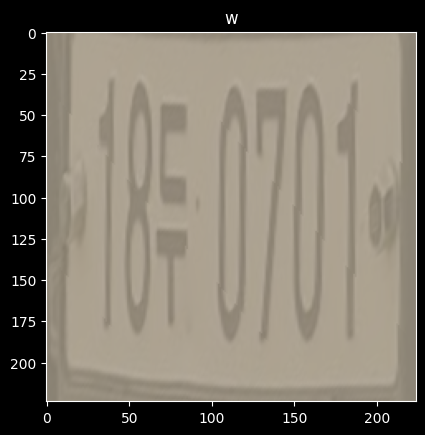

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


images, labels = next(iter(train_loader))
imshow(images[0], title=class_names[labels[0]])
save_image(images[0], "nguyen.png")

In [9]:
def visualize_model(model, test_loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
resnet_50 = models.resnet50(weights="IMAGENET1K_V2")

resnet_50 = nn.Sequential(*list(resnet_50.children())[:-1])
for param in resnet_50.parameters():
    param.requires_grad = False

# Define the custom head for your model
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super(Net, self).__init__()
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(2048, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.softmax(x)
        return x

# Combine the ResNet base and the custom head
model = nn.Sequential(resnet_50, Net())
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(model)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [11]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print average training loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

            # For accuracy calculation
            _, predictions = torch.max(val_outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(val_targets.cpu().numpy())

    # Calculate average validation loss
    average_val_loss = val_loss / len(val_loader)
    print(f'Validation Epoch [{epoch + 1}/{num_epochs}], Loss: {average_val_loss:.4f}')

    # Calculate and print accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Optional: Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

Training Epoch [1/10], Loss: 1.0288
Validation Epoch [1/10], Loss: 0.7848
Validation Accuracy: 95.94%
Training Epoch [2/10], Loss: 0.8468
Validation Epoch [2/10], Loss: 0.7595
Validation Accuracy: 98.19%
Training Epoch [3/10], Loss: 0.7877
Validation Epoch [3/10], Loss: 0.7504
Validation Accuracy: 99.29%
Training Epoch [4/10], Loss: 0.7652
Validation Epoch [4/10], Loss: 0.7492
Validation Accuracy: 99.51%
Training Epoch [5/10], Loss: 0.7639
Validation Epoch [5/10], Loss: 0.7494
Validation Accuracy: 99.45%
Training Epoch [6/10], Loss: 0.7613
Validation Epoch [6/10], Loss: 0.7488
Validation Accuracy: 99.51%
Training Epoch [7/10], Loss: 0.7596
Validation Epoch [7/10], Loss: 0.7497
Validation Accuracy: 99.40%
Training Epoch [8/10], Loss: 0.7573
Validation Epoch [8/10], Loss: 0.7487
Validation Accuracy: 99.45%
Training Epoch [9/10], Loss: 0.7563
Validation Epoch [9/10], Loss: 0.7485
Validation Accuracy: 99.51%
Training Epoch [10/10], Loss: 0.7580
Validation Epoch [10/10], Loss: 0.7493
Valida

In [12]:
# Step 4: Test the Model
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # if predicted.item() != targets.item():
        #     print(f"{targets.item()} and {predicted.item()}")
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

# Calculate and print the accuracy
accuracy = correct_predictions / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 99.62%


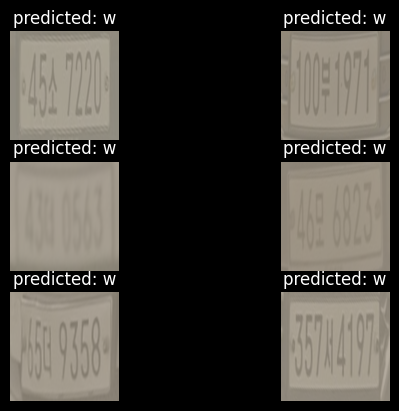

In [13]:
visualize_model(model, test_loader)

In [14]:
path = '/home/deeplearner/ai-vn/projects/nguyen/test/e/'
check_list = os.listdir(path)
g = 0
e = 0
w = 0
y = 0

model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

for i in check_list:
    img_path = os.path.join(path, i)
    img = Image.open(img_path)
    img = transform(img)
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    with torch.no_grad():
        predictions = model(img)

    class_id = torch.argmax(predictions, dim=1).item()

    if class_id == 0:
        e += 1
    elif class_id == 1:
        g += 1
    elif class_id == 2:
        w += 1
    elif class_id == 3:
        y += 1

    print(f"{class_id}: {class_names[class_id]}")

print(e / (e + g + w + y))


0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
2: w
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0: e
0.9565217391304348


Confusion Matrix:
[[  22    0    1    0]
 [   0   58    1    0]
 [   1    2 1655    0]
 [   0    0    2   83]]
Classification Report:
              precision    recall  f1-score   support

           e       0.96      0.96      0.96        23
           g       0.97      0.98      0.97        59
           w       1.00      1.00      1.00      1658
           y       1.00      0.98      0.99        85

    accuracy                           1.00      1825
   macro avg       0.98      0.98      0.98      1825
weighted avg       1.00      1.00      1.00      1825



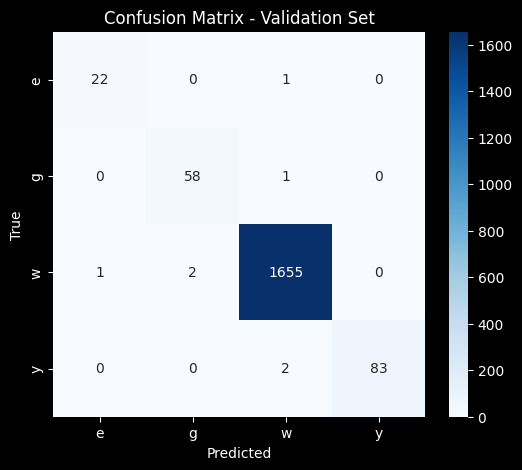

In [15]:
def evaluate_model(model, dataloader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(all_labels, all_preds, target_names=class_names,zero_division=True)
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
evaluate_model(model, test_loader, class_names)
